## Imports

In [1]:
# pip install --upgrade scikit-learn


In [52]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt

import sklearn
from sklearn import pipeline      # Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler # OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn import compose
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", sklearn.__version__) # Try to use 0.24

Pandas   1.4.1
Sklearn  1.0.2


## Get the dataset
- **CLOUD = True**: Download dataset from Kaggle. Necesary for cloud enviroments like COLAB. **Specify your [kaggle credentials](https://www.kaggle.com/docs/api)**.
- **CLOUD = False**: Get the dataset from your local machine. **Specify the data path**.

In [3]:
DATA_PATH = "./titanic/"

## Load data

In [4]:
df      = pd.read_csv(DATA_PATH + "train.csv", index_col='PassengerId')
df_test = pd.read_csv(DATA_PATH + "test.csv",  index_col='PassengerId')

print("Train DataFrame:", df.shape)
print("Test DataFrame: ", df_test.shape)

Train DataFrame: (891, 11)
Test DataFrame:  (418, 10)


In [5]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [6]:
df.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
465,0,3,"Maisner, Mr. Simon",male,NaN,0,0,A/S 2816,8.0500,NaN,S
30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S
583,0,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,NaN,S
547,1,2,"Beane, Mrs. Edward (Ethel Clarke)",female,19.0,1,0,2908,26.0000,NaN,S
854,1,1,"Lines, Miss. Mary Conover",female,16.0,0,1,PC 17592,39.4000,D28,S
281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q
821,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S


In [7]:
df_test.sample(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1251,3,"Lindell, Mrs. Edvard Bengtsson (Elin Gerda Per...",female,30.0,1,0,349910,15.5500,NaN,S
1161,3,"Pokrnic, Mr. Mate",male,17.0,0,0,315095,8.6625,NaN,S
964,3,"Nieminen, Miss. Manta Josefina",female,29.0,0,0,3101297,7.9250,NaN,S
906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",female,47.0,1,0,W.E.P. 5734,61.1750,E31,S
1002,2,"Stanton, Mr. Samuel Ward",male,41.0,0,0,237734,15.0458,NaN,C
909,3,"Assaf, Mr. Gerios",male,21.0,0,0,2692,7.2250,NaN,C
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
983,3,"Pedersen, Mr. Olaf",male,NaN,0,0,345498,7.7750,NaN,S
1280,3,"Canavan, Mr. Patrick",male,21.0,0,0,364858,7.7500,NaN,Q


## Check missings

In [8]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

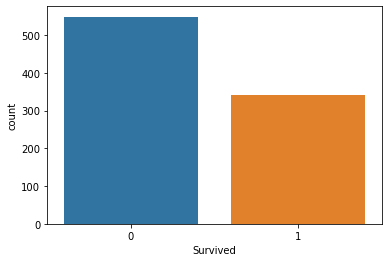

In [48]:
# Target
sb.countplot(x = df.Survived)

In [9]:
df_test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

`Age` and `Cabin` are missing data in both training and test sets. Missing values in `Cabin` are way higher, might be a good idea to drop the whole column.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

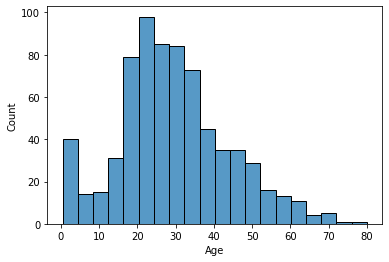

In [10]:
# How is Age distributed?

sb.histplot(x = df['Age'])

df['Age'].describe()


The `Age` is skewed to the right. While looking for a better way to replace missing values (e.g. based on some grouping factor, or KNN), we'll use the median as replacement.   
Also something noticeable is that the mininum age is 0.42 (probably because they are converting months to years).

In [11]:
df.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

# Exercise 1 (2pts):
Extract the title (Mr, Mrs, ... ) from the "Name" column.

Tips:
- split(',')[1] to get the 2nd part, and remove the surnamename
- split('.')[0] to get the 1str part, and remove the name

In [12]:
# CODE HERE get_Title_from_Name funtion
# Create this function using lambda (not def)

get_Title_from_Name = lambda x: x.split(',')[1].split('.')[0].strip()

df['Title'] = df['Name'].apply(get_Title_from_Name)
df_test['Title'] = df_test['Name'].apply(get_Title_from_Name)

In [13]:
df.Title.value_counts(), df_test.Title.value_counts()

(Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
 Name: Title, dtype: int64,
 Mr        240
 Miss       78
 Mrs        72
 Master     21
 Col         2
 Rev         2
 Ms          1
 Dr          1
 Dona        1
 Name: Title, dtype: int64)

In [14]:
assert df['Title'].values[0] == "Mr"
assert df['Title'].values[1] == "Mrs"
assert df['Title'].values[2] == "Miss"

assert df_test['Title'].values[0] == "Mr"
assert df_test['Title'].values[1] == "Mrs"
assert df_test['Title'].values[414] == "Dona"

# Exercise 2 (1pts):
Apply the title_dictionary to get a better information about the title. You have to overwrite the Title variable.

In [15]:
title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

In [16]:
# Use map to apply the prevous dict

df['Title'] = df['Title'].map(title_dictionary) 
df_test["Title"] = df_test['Title'].map(title_dictionary) 



In [17]:
assert df['Title'].values[886] == "Officer"
assert df_test['Title'].values[417] == "Master"

# Exercise OPTIONAL (0pts):
Try to extract some information from the feature **Ticket**. Search on Internet if that colum has some kind of information.

# Exercise OPTIONAL (0pts):
Try to extract some information from the feature **Cabin**. Search on Internet if that colum has some kind of information.

# Preprocessing
For X data, notice that...
- We drop Survived because is the target variable
- We drop Name because we have extracted the Title: Mr, Mrs, ...
- We drop Ticket because it has no information -> see df.Ticket.nunique()
- We drop Cabin because it has a lot of missings (77% are missings)

Then, we identify **numerical** variables and **categorical** variables,

In [18]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes

x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin']) # # X_TEST DATA (NEW DATA)

In [19]:
print(x.shape, y.shape, x_test.shape)

(891, 8) (891,) (418, 8)


In [20]:
cat_vars  = ['Sex', 'Embarked', 'Title']         # x.select_dtypes(include=[object]).columns.values.tolist()
num_vars  = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age'] # x.select_dtypes(exclude=[object]).columns.values.tolist()

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)


Numerical features:
 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']

Categorical features:
 ['Sex', 'Embarked', 'Title']


# Exercise 3 (2pts):
Create a **ColumnTransformer for Tree Models**. You need to create 2 pipelines (one for numerical and other for categories). Remember:
- Categorical pipeline: Some SimpleImputer -> Some Encoder
- Numerical pipeline: Some SimpleImputer -> NO Encoder

In [21]:
"""
num_preprocessing = pipeline.Pipeline(steps=[
  # Some SimpleImputer here
])

cat_preporcessing = pipeline.Pipeline(steps=[
  # Some SimpleImputer here
  # Some Encoder here. Remember to handle_unknown
])

tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_preprocessing, num_vars),
    ('cat', cat_preporcessing, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_prepro
""";

### BEGIN SOLUTION


In [22]:
num_4_treeModels = pipeline.Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean'))
])

cat_4_treeModels = pipeline.Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
  ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Sex', 'Embarked', 'Title'])])

In [23]:
assert type(tree_prepro)      is compose._column_transformer.ColumnTransformer
assert type(num_4_treeModels) is pipeline.Pipeline
assert type(cat_4_treeModels) is pipeline.Pipeline
assert len(num_4_treeModels) == 1
assert len(cat_4_treeModels) == 2

# Exercise 4 (1pts):
1. Complete the diccionary with some Tree Models.
2. Then we put each model in a Pipeline where:
   - first is the prepocessing with the column Transformer
   - Then is the Tree model
3. Display the fullpipeline of the LGBMClassifier

In [24]:
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
# from sklearn.experimental  import enable_hist_gradient_boosting # Necesary for HistGradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier

C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [27]:
tree_classifiers = {
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees": ExtraTreesClassifier(),
  "Random Forest":RandomForestClassifier(),
  "AdaBoost": AdaBoostClassifier(),
  "Skl GBM": GradientBoostingClassifier(),
  "Skl HistGBM": HistGradientBoostingClassifier(),
  "XGBoost": XGBClassifier(),
  "LightGBM": LGBMClassifier(),
  "CatBoost": CatBoostClassifier()}


tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}
tree_classifiers["LightGBM"]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [28]:
for pipe in tree_classifiers.values():
    assert type(pipe) is pipeline.Pipeline

# Exercise 5 (3pts):
Define a simple split validation strategy with:
- 80% for train
- 20% for validation
- With stratification
- random_state=0

And train all the models in a for loop

In [59]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(712, 8) (712,) (179, 8) (179,)


In [60]:
results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

for model_name, model in tree_classifiers.items():
    start_time = time.time()
    
    # Training
    model.fit(x_train, y_train)
    
    # GET PREDICTIONS USING x_val
    pred = model.predict(x_val)

    total_time = time.time() - start_time # Time taken to fit on train and predict on validation sets

    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
                              
                              

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\689382431.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\689382431.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\689382431.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\689382431.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    mode

[17:14:45] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\689382431.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\689382431.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,


Learning rate set to 0.008911
0:	learn: 0.6896726	total: 896us	remaining: 895ms
1:	learn: 0.6840036	total: 3.28ms	remaining: 1.64s
2:	learn: 0.6784911	total: 6.14ms	remaining: 2.04s
3:	learn: 0.6726585	total: 8.82ms	remaining: 2.2s
4:	learn: 0.6659867	total: 10.8ms	remaining: 2.14s
5:	learn: 0.6602370	total: 13.5ms	remaining: 2.24s
6:	learn: 0.6544571	total: 15.4ms	remaining: 2.19s
7:	learn: 0.6500395	total: 16.8ms	remaining: 2.09s
8:	learn: 0.6447847	total: 18.8ms	remaining: 2.06s
9:	learn: 0.6418760	total: 20.1ms	remaining: 1.99s
10:	learn: 0.6367787	total: 22.6ms	remaining: 2.04s
11:	learn: 0.6315598	total: 25.3ms	remaining: 2.08s
12:	learn: 0.6262804	total: 27.5ms	remaining: 2.09s
13:	learn: 0.6206929	total: 29.5ms	remaining: 2.07s
14:	learn: 0.6163623	total: 32.2ms	remaining: 2.12s
15:	learn: 0.6119482	total: 34.9ms	remaining: 2.15s
16:	learn: 0.6079552	total: 39.4ms	remaining: 2.28s
17:	learn: 0.6032971	total: 41.6ms	remaining: 2.27s
18:	learn: 0.5987748	total: 43ms	remaining: 2.

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\689382431.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,


In [61]:
results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

,Model,Accuracy,Bal Acc.,Time
1,Skl GBM,84.916201,82.595520,0.185994
2,XGBoost,81.564246,78.787879,0.192995
3,Skl HistGBM,81.005587,78.603426,0.977109
4,LightGBM,81.005587,78.333333,0.212005
5,AdaBoost,79.888268,77.964427,0.125036
6,Random Forest,79.329609,76.699605,0.336999
7,CatBoost,79.329609,76.969697,2.716854
8,Decision Tree,77.653631,76.146245,0.037002
9,Extra Trees,75.418994,72.977602,0.357111


In [44]:
"""
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    # CODE HERE
)
"""

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

"""
for model_name, model in tree_classifiers.items():
    start_time = time.time()
    
    # FOR EVERY PIPELINE (PREPRO + MODEL) -> TRAIN WITH TRAIN DATA (x_train)
    
    # GET PREDICTIONS USING x_val
    pred = # CODE HERE

    total_time = time.time() - start_time

    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
                              
                              
"""

### BEGIN SOLUTION




results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

C:\Users\Jon\.conda\envs\NLP\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[08:59:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.073611
0:	learn: 0.6694333	total: 149ms	remaining: 14.8s
1:	learn: 0.6480457	total: 150ms	remaining: 7.36s
2:	learn: 0.6295837	total: 151ms	remaining: 4.87s
3:	learn: 0.6077415	total: 151ms	remaining: 3.63s
4:	learn: 0.5921743	total: 152ms	remaining: 2.89s
5:	learn: 0

,Model,Accuracy,Bal Acc.,Time
1,Skl GBM,86.592179,85.039526,0.071807
2,CatBoost,84.916201,82.865613,0.335109
3,XGBoost,83.798883,82.766798,0.067819
4,LightGBM,83.798883,82.766798,0.053856
5,AdaBoost,82.681564,82.127800,0.117685
6,Skl HistGBM,82.681564,81.317523,0.354052
7,Random Forest,82.122905,80.592885,0.111702
8,Extra Trees,80.446927,78.959157,0.096741
9,Decision Tree,76.536313,75.777339,0.010972


In [62]:
assert results_ord["Accuracy"].min() > 75
assert results_ord["Bal Acc."].min() > 75
assert len(results_ord) == 9

AssertionError: 

# Exercise 6 (3pts):
Define a 10 Fold cross validation strategy with:
- With stratification
- shuffle=True
- random_state=0

And train all the models in a for loop.

Tip you can use **[cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)** for both training and predict with 

In [63]:
skf = StratifiedKFold(10, shuffle=True, random_state=0)

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})


for model_name, model in tree_classifiers.items():
    start_time = time.time()
        
    # TRAIN AND GET PREDICTIONS USING cross_val_predict() and x,y
    pred = cross_val_predict(model, x_val, y_val, cv = skf)

    total_time = time.time() - start_time

    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\1732824646.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\1732824646.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\1732824646.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\1732824646.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    

[17:17:09] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\1732824646.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\1732824646.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,


Learning rate set to 0.004723
0:	learn: 0.6914102	total: 621us	remaining: 621ms
1:	learn: 0.6891635	total: 1.66ms	remaining: 830ms
2:	learn: 0.6873137	total: 2.44ms	remaining: 812ms
3:	learn: 0.6857697	total: 3.21ms	remaining: 801ms
4:	learn: 0.6840979	total: 3.86ms	remaining: 768ms
5:	learn: 0.6824432	total: 4.69ms	remaining: 777ms
6:	learn: 0.6802609	total: 5.79ms	remaining: 821ms
7:	learn: 0.6782633	total: 7.24ms	remaining: 898ms
8:	learn: 0.6756593	total: 9.97ms	remaining: 1.1s
9:	learn: 0.6735123	total: 11ms	remaining: 1.09s
10:	learn: 0.6708768	total: 12.1ms	remaining: 1.09s
11:	learn: 0.6685367	total: 13.5ms	remaining: 1.11s
12:	learn: 0.6659007	total: 14.8ms	remaining: 1.12s
13:	learn: 0.6640158	total: 15.8ms	remaining: 1.11s
14:	learn: 0.6619580	total: 17.1ms	remaining: 1.12s
15:	learn: 0.6597245	total: 18.5ms	remaining: 1.14s
16:	learn: 0.6581960	total: 19.4ms	remaining: 1.12s
17:	learn: 0.6567437	total: 20.1ms	remaining: 1.09s
18:	learn: 0.6550727	total: 20.9ms	remaining: 1.

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12284\1732824646.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,


,Model,Accuracy,Bal Acc.,Time
1,CatBoost,79.888268,76.613966,18.062385
2,Random Forest,78.212291,76.600791,2.154182
3,Skl HistGBM,78.212291,75.790514,2.695749
4,XGBoost,77.653631,75.876153,1.506385
5,Skl GBM,76.536313,74.426877,0.961920
6,Extra Trees,74.301676,72.878788,1.858562
7,LightGBM,74.301676,72.338603,0.769402
8,Decision Tree,73.184358,72.239789,0.327529
9,AdaBoost,72.067039,69.980237,1.168477


In [46]:
"""
skf = model_selection.StratifiedKFold(
    # CODE HERE
)
"""



results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

"""
for model_name, model in tree_classifiers.items():
    start_time = time.time()
        
    # TRAIN AND GET PREDICTIONS USING cross_val_predict() and x,y
    pred = # CODE HERE

    total_time = time.time() - start_time

    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
                              
                              
"""


results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

ms	remaining: 190ms
20:	learn: 0.4379520	total: 48.4ms	remaining: 182ms
21:	learn: 0.4337524	total: 49.1ms	remaining: 174ms
22:	learn: 0.4304046	total: 49.7ms	remaining: 166ms
23:	learn: 0.4268015	total: 50.7ms	remaining: 160ms
24:	learn: 0.4234316	total: 51.7ms	remaining: 155ms
25:	learn: 0.4199055	total: 52.7ms	remaining: 150ms
26:	learn: 0.4162630	total: 53.6ms	remaining: 145ms
27:	learn: 0.4137693	total: 54.3ms	remaining: 140ms
28:	learn: 0.4119374	total: 55.2ms	remaining: 135ms
29:	learn: 0.4097722	total: 56ms	remaining: 131ms
30:	learn: 0.4074941	total: 56.9ms	remaining: 127ms
31:	learn: 0.4055535	total: 57.8ms	remaining: 123ms
32:	learn: 0.4033087	total: 58.8ms	remaining: 119ms
33:	learn: 0.4012196	total: 59.7ms	remaining: 116ms
34:	learn: 0.3991772	total: 60.6ms	remaining: 113ms
35:	learn: 0.3972488	total: 61.5ms	remaining: 109ms
36:	learn: 0.3961493	total: 62.4ms	remaining: 106ms
37:	learn: 0.3944826	total: 63.3ms	remaining: 103ms
38:	learn: 0.3928820	total: 64.3ms	remaining: 

,Model,Accuracy,Bal Acc.,Time
1,Skl GBM,83.277217,81.027706,0.782907
2,CatBoost,82.716049,80.241588,1.593758
3,Skl HistGBM,82.491582,80.831176,3.700102
4,LightGBM,82.491582,80.886300,1.059167
5,Random Forest,82.042649,80.687374,1.328446
6,AdaBoost,81.930415,80.927044,1.246664
7,XGBoost,81.930415,80.430927,0.744010
8,Extra Trees,80.808081,79.354808,1.219739
9,Decision Tree,79.124579,77.933563,0.143615


In [51]:
assert results_ord["Accuracy"].min() > 75
assert results_ord["Bal Acc."].min() > 75
assert len(results_ord) == 9

AssertionError: 

# Exercise 7.1
Train with all data the best model

In [42]:
best_model = tree_classifiers["Skl GBM"]

# Fit best model with all data
best_model.fit(x, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

# Exercise 7.2 (2pts)
With your best model, generate the predicitions for test data (x_test)

In [44]:
# test_pred = # Get the predictions for x_test
test_pred = best_model.predict(x_test)



In [45]:
assert len(test_pred) == 418
assert np.unique(test_pred).tolist() == [0,1]

# Exercise 7.3

Submit to kaggle.

- You can use the kaggle command line app. Check https://github.com/Kaggle/kaggle-api

In [51]:
"""sub = pd.DataFrame(test_pred, index=x_test.index, columns=["Survived"])
sub.head()"""

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [52]:
'''sub.to_csv("sub.csv")'''

In [53]:
!kaggle competitions submit -c titanic -f sub.csv -m "My submission message"

'kaggle' is not recognized as an internal or external command,
operable program or batch file.
